# Load Packages and Data

## Packages

In [68]:
import contextily as ctx
import geopandas as gpd
import fiona
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'white'
import numpy as np
import xarray as xr
import os

## Links and Variables

In [69]:
# Data pulled from Community Snow Obs Website
data = 'Mesa_Snow_Heights.geojson'

# boundary KML File form snowex Flights
boundaries = 'Boundary_KMLs/PLAN_1585_v01_all_swaths_Jan22-May7.kml'

# Make output directory
try: 
    os.mkdir('/output')
    print('made directory')
except:
    print('didn''t make a directory')


didnt make a directory


## Read in the Datasets

In [70]:
# Read in the CSO Data
df = gpd.read_file(data)

# use fiona to load in the kml files from the flight boundaries
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
flight_bound = gpd.read_file(boundaries, driver='KML')

# Clean up the string a bit
flight_bound['Name'] = flight_bound['Name'].str[0:-18]

# Merge the polygons

In [71]:
# Create subset for boundary to play with
FB = flight_bound

# Join the flights (JF) by using dissolve command
JF = FB.dissolve( by = 'Name', as_index = False )

#rebrand
flight_bound = JF
flight_bound

,Name,geometry,Description
0,alamos,"POLYGON ((-106.54263 35.69443, -106.30516 35.6...",
1,donner,"POLYGON ((-120.68709 39.16362, -120.49122 39.0...",
2,dorado,"POLYGON ((-120.17491 38.61286, -119.93997 38.6...",
3,fraser,"POLYGON ((-105.93258 39.77722, -106.01819 39.7...",
4,grmesa,"POLYGON ((-107.85779 39.09555, -107.80946 39.0...",
5,irnton,"POLYGON ((-107.90969 37.71257, -107.67724 37.6...",
6,lowman,"POLYGON ((-116.20918 43.61008, -116.29838 43.5...",
7,peeler,"POLYGON ((-106.79736 38.81616, -106.75989 38.7...",
8,rockmt,"POLYGON ((-105.54823 40.37152, -105.54790 40.3...",
9,sierra,"POLYGON ((-118.80649 37.05823, -118.79514 36.9...",


## Check the projections and metadata of each dataset

In [72]:
# do the projections match?
TF = flight_bound.crs == df.crs # test if they are equal
print(f'Do the flight and point data have the same projection: {TF} \n')

print('What Projection are they in: ')
print(f'Depth Projection: {df.crs}')
print(f'Flight Projection: {flight_bound.crs}')

Do the flight and point data have the same projection: True 

What Projection are they in: 
Depth Projection: epsg:4326
Flight Projection: epsg:4326


## Visualize

<Figure size 4000x4000 with 0 Axes>

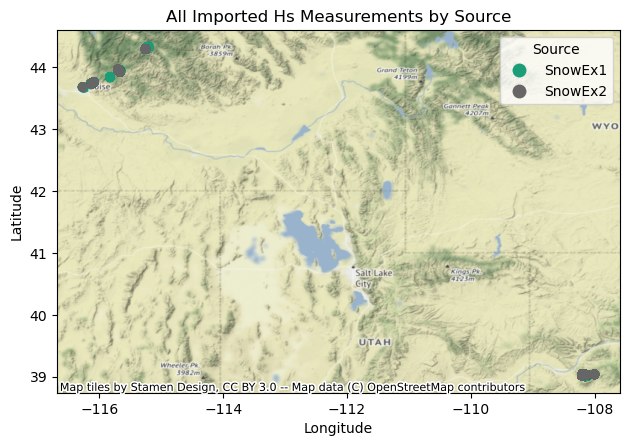

In [73]:
fig = plt.figure(figsize=(40, 40))
ax1 = df.plot(column = 'Source',
    cmap = 'Dark2', # set the colormap 
    legend = True, # Turn on the legend  
    legend_kwds={
        # 'bbox_to_anchor': (0.6 , 0.8) , # push the legend off the map
        'title': 'Source' # Label the legend
        }, 
    )

# Add the basemap
ctx.add_basemap(ax1, # Add to the current axis
    crs=df.crs, # Assign the same CRS as the Dataframe
    source=ctx.providers.Stamen.TerrainBackground) # Determine what the base map is

# labels and titles
plt.title('All Imported Hs Measurements by Source')
plt.ylabel('Latitude')
plt.xlabel('Longitude')
# add the base map
ctx.add_basemap(ax1, crs=df.crs)


plt.tight_layout()
# plt.savefig('output/All_Submitted_Hs.png', dpi = 300)
plt.show()

# Clean

## Clip to the boundaries

In [74]:
# add a site column to the dataframe
df["Site"] = np.nan

# set the order of the columns
df = df [['Source' , 'Site' , 'Name' , 'Depth' , 'Altitude (ft)' , 'Accuracy (ft)' , 'Date/Time',
           'Latitude' , 'Longitude' , 'Location' , 'geometry' , 'Description' , 'User' , 'Attachment'	]]

# clip to the boundaries
df = gpd.clip(df , flight_bound) # clip the dataframe to the flight boundaries

# Assign a Site to each point
for index, row in df.iterrows(): # for the indices and rows 
    point = row["geometry"] # pull the geometry to test
    for num, ob in flight_bound.iterrows(): # for ever 
        if point.within(ob["geometry"]): 
            df["Site"][index] = ob["Name"]  # set the site label at theindex to the flight boundary name

# df.to_file('/output/All_Hs_Measurements.geojson', driver = 'GeoJSON')
df['Site'] = df['Site'].astype(str)
display(df.dtypes)

C:\Users\Owner\AppData\Local\Temp\ipykernel_19224\3545266014.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Site"][index] = ob["Name"]  # set the site label at theindex to the flight boundary name


Source             object
Site               object
Name               object
Depth               int64
Altitude (ft)     float64
Accuracy (ft)     float64
Date/Time          object
Latitude          float64
Longitude         float64
Location           object
geometry         geometry
Description        object
User               object
Attachment         object
dtype: object

## Plot it again

<Figure size 70000x30000 with 0 Axes>

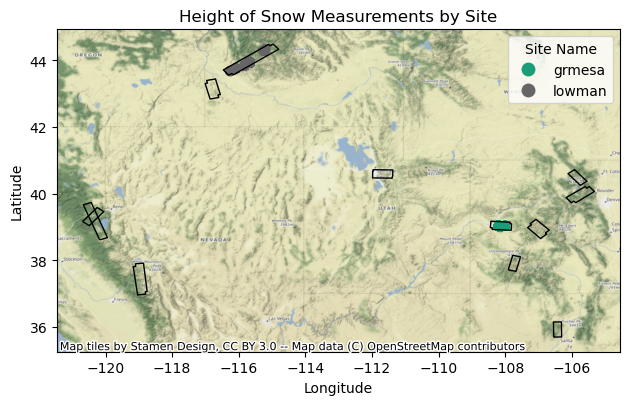

In [137]:
fig = plt.figure(figsize=(700, 300))
# Plot the points
ax1 = df.plot(column = 'Site' , # sorting by the site
    cmap = 'Dark2', # set the colormap 
    legend = True, # Turn on the legend
    legend_kwds={
        # 'bbox_to_anchor': (1, 1.1) , # push the legend off the map
        'title': 'Site Name' # Label the legend
        }, 
    )
# Plot the boundaries
flight_bound.plot(ax = ax1 , 
    facecolor = 'none' , # empty polygons 
    edgecolor = 'black') # determine the edge color
plt.title('Height of Snow Measurements by Site')
plt.ylabel('Latitude')
plt.xlabel('Longitude')

# add the base map
ctx.add_basemap(ax1, crs=df.crs)
plt.tight_layout()
# plt.savefig('output/All_Sites_Map.png', dpi = 300)
plt.show()


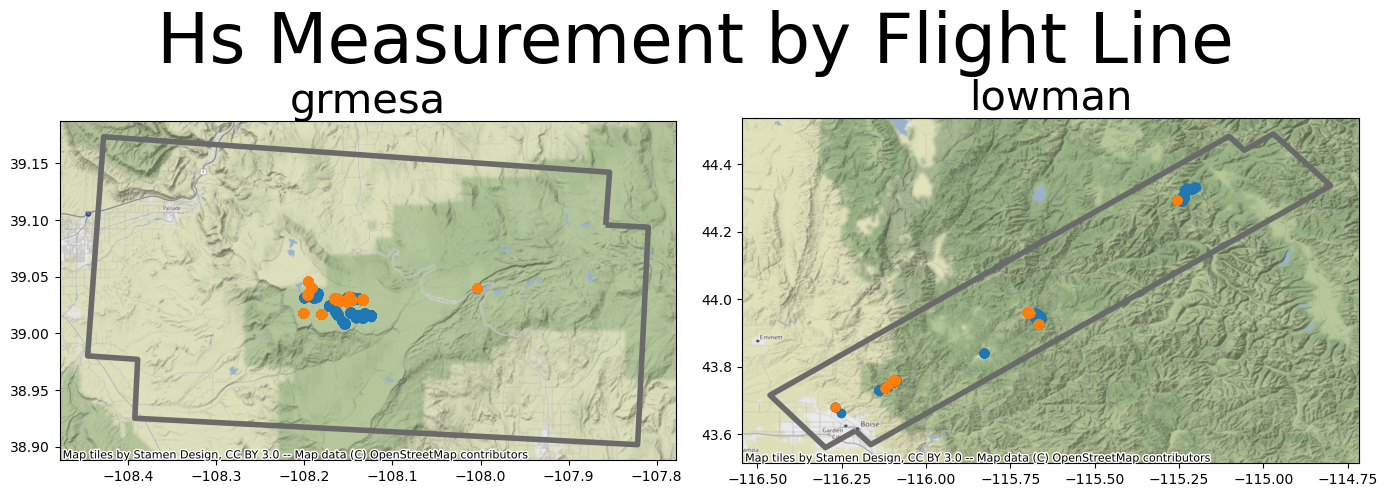

In [169]:
fig, ax1 = plt.subplots(1, 2, figsize=(14, 5))

# first round
flight_bound.loc[[4],'geometry'].plot(
    ax=ax1[0], # plot it on the current figure axis (idx)
    facecolor = 'none', # make sure there is no fill
    edgecolor='#6a6a6a', # Turn the edges black
    linewidth= 4, # Line width
    )
    
ctx.add_basemap(ax1[0], crs=df.crs)

ax1[0].set_title(f"{flight_bound.iloc[4]['Name']}", # Set the title to the Site
    fontsize = 30) # Set the font size

    # # else plot the new ones
dnew = df[df['Site'] == flight_bound['Name'][4] ]
# dnew.plot()
dnew.groupby('Source').plot(ax=ax1[0] ,  
    legend = True, # Turn on the legend
    legend_kwds={
        'bbox_to_anchor': (1, 1.1) , # push the legend off the map
        'title': 'Source' # Label the legend
        }, 
    )

# Second Round
    # # else plot the new ones
dnew = df[df['Site'] == flight_bound['Name'][6] ]
# dnew.plot()
dnew.groupby('Source').plot(ax=ax1[1] , 
    )

flight_bound.loc[[6],'geometry'].plot(
    ax=ax1[1], # plot it on the current figure axis (idx)
    facecolor = 'none', # make sure there is no fill
    edgecolor='#6a6a6a', # Turn the edges black
    linewidth= 4, # Line width
    )
    
ctx.add_basemap(ax1[1], crs=df.crs)

ax1[1].set_title(f"{flight_bound.iloc[6]['Name']}", # Set the title to the Site
    fontsize = 30) # Set the font size




plt.suptitle('Hs Measurement by Flight Line',  # Set the overall title
    fontsize = 50
    )

plt.tight_layout()
# plt.savefig('output/Individual_Sites.png', dpi = 300)
plt.show()

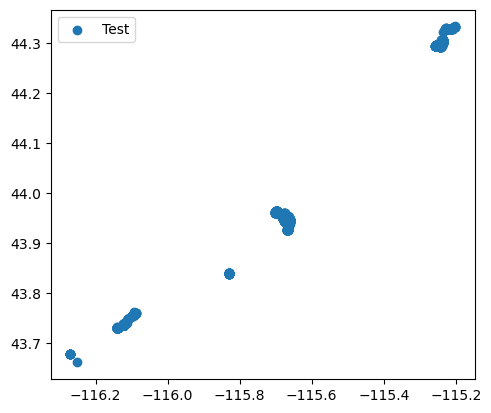

In [193]:
# Second Round
    # # else plot the new ones
dnew = df[df['Site'] == flight_bound['Name'][6] ]
# dnew.plot()
fig = dnew.plot(
    # ax=ax1[1] , 
    legend = True,
    legend_kwds={
        'bbox_to_anchor': (1, 1.1) , # push the legend off the map
        'title': 'Source' # Label the legend
        }, 
    )
ax = plt.gca()
ax.legend(['Test' , 'test2'])